# Filtering Melody Notes 

### Helper Functions

In [3]:
from random import randrange
import numpy as np
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
import miditoolkit as mtk

def filterMelodyNotes(notes,method=2,threshold=2):
    """
    Filter out melody notes.
    Returns a tuple of (normal notes,melody notes)
    """
    # sort notes by start time and makes their lengths 1 tick
    notes=sorted(notes,key=lambda x:x.start)
    for note in notes:
        note.end=note.start+1
    normal_notes=[]
    melody_notes=[]
    if method==1:
        window_length_time=4

        # group notes by which window they belong to

        song_start=notes[0].start
        song_end=notes[-1].end

        num_windows=int((song_end-song_start)/window_length_time)

        windows=[[] for i in range(num_windows)]

        for note in notes:
            window_index=int((note.start-song_start)/window_length_time)
            windows[window_index].append(note)

        # filter melody notes
        for window_index,window in enumerate(windows):
            for note in window:
                context_notes=notesBetween(note.start-window_length_time,note.start,notes)
                if isMelodyNote(note,context_notes):
                    melody_notes.append(note)
                else:
                    normal_notes.append(note)

    if method==2:
        # for simultaneous notes keep the one with highest velocity
        for i,note in enumerate(notes):
            simultaneous_notes=notesBetween(note.start-threshold,note.end+threshold,notes)
            if len(simultaneous_notes)>1:
                melody_note=max(simultaneous_notes,key=lambda x:x.velocity)
                if note.velocity>=melody_note.velocity:
                    melody_notes.append(note)
                else:
                    normal_notes.append(note)
            else:
                melody_notes.append(note)

    return normal_notes,melody_notes


def notesBetween(start_time,end_time,notes):
    """
    Get notes between start_time and end_time.
    """
    return [note for note in notes if (note.start>=start_time and note.end<=end_time) or (note.start<=start_time and note.end>=start_time)]

def isMelodyNote(note,context_notes,heuristic="velocity",params=None):
    """
    Check if a note is a ghost note.
    """
    heuristic=heuristics[heuristic]
    return heuristic(note,context_notes,params)

def velocityThreshold(test_note,context_notes,params):
    ''' 
    Detect outliers in velocity.
    '''
    method=params["method"] if params is not None else 1
    all_velocities=[note.velocity for note in context_notes]+[test_note.velocity]
    outliers=getOutliers(all_velocities,method)

    # check if test_note is an outlier
    if test_note.velocity in outliers:
        return True

def getOutliers(data,method=1):
    if method==1:
        outliers=[]
        
        z_threshold=1
        median = np.median(data)
        std =np.std(data,)
        
        
        for y in data:
            z_score= (y - median)/std
            if z_score>z_threshold:
                outliers.append(y)
    elif method==2:
        data=sorted(data)
        q1, q3= np.percentile(data,[25,75])
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        outliers=[]
        for y in data:
            if y<lower_bound:
                outliers.append(y)
    return outliers

def split2midi(normal_notes,melody_notes):
    """
    Convert a list of notes to a midi file where first instrument is normal notes and second instrument is ghost notes.
    """
    normal_notes = [note for note in normal_notes if note.velocity != 0]
    melody_notes = [note for note in melody_notes if note.velocity != 0]
    mido_obj = mid_parser.MidiFile()
    beat_resol = mido_obj.ticks_per_beat

    # create instruments
    melody_instrument = mid_parser.Instrument(program=0)
    melody_instrument.name= "Melody Notes"

    normal_instrument = mid_parser.Instrument(program=1)
    normal_instrument.name= "Normal Notes"
    
    mido_obj.instruments.append(melody_instrument)
    mido_obj.instruments.append(normal_instrument)
    
    melody_instrument.notes = melody_notes
    normal_instrument.notes = normal_notes
    
    return mido_obj

def extractMelody(midi_file,output_filename="melody.mid",instrument=-1,threshold=2):
    """
    Extract melody from midi file.
    """
    midi_file=mtk.MidiFile(midi_file)
    notes=[]
    if instrument==-1:
        for i,track in enumerate(midi_file.instruments):
            notes+=track.notes
    else:
        notes=midi_file.instruments[instrument].notes
    notes=sorted(notes,key=lambda x:x.start)
    normal_notes,melody_notes=filterMelodyNotes(notes,method=2,threshold=threshold)
    out_midi=split2midi(normal_notes,melody_notes)
    out_midi.dump(output_filename)

    
heuristics={
    "velocity":velocityThreshold,
}

In [5]:
threshold=50
extractMelody(midi_file,"temp2.mid",instrument=-1,threshold=threshold)

### Read annotations

In [ ]:
import pandas as pd
from utils import read_annotations

ASAP="Sample_Data/asap-dataset"
annotations_path=f"{ASAP}/asap_annotations.json"

annotations=read_annotations(annotations_path,process=False)

# unique score_filename values
score_filenames = annotations['score_filename'].unique()

performance_filenames = annotations['performance_filename'].unique()

### Extract melody for composers

In [ ]:
from tqdm import tqdm
import miditoolkit as mtk
import os

samples=2
output_folder="Store/Filter"
composers=["Bach","Chopin","Mozart"]

ASAP_DIR="Sample_Data/asap-dataset"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

counts=[0 for i in range(len(composers))]

for filename in tqdm(performance_filenames):
    composer=filename.split("/")[0]
    if composer in composers and counts[composers.index(composer)]<samples:
        counts[composers.index(composer)]+=1
        full_filename=f"{ASAP_DIR}/{filename}"
        
        output_filename=f"{composer}_{filename.split('/')[-1]}"
        output_filename=f"{output_folder}/{output_filename}"

        extractMelody(full_filename,output_filename)

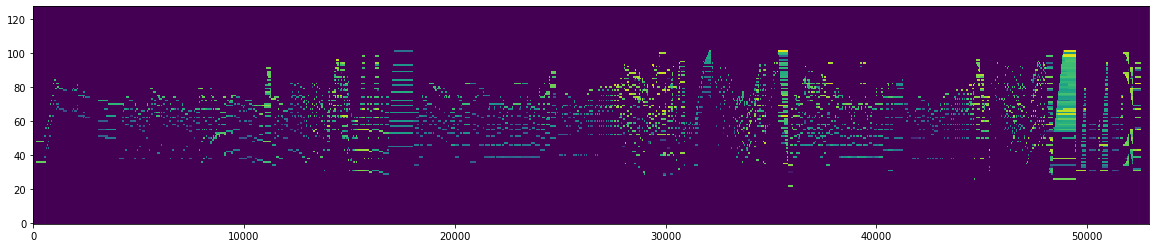

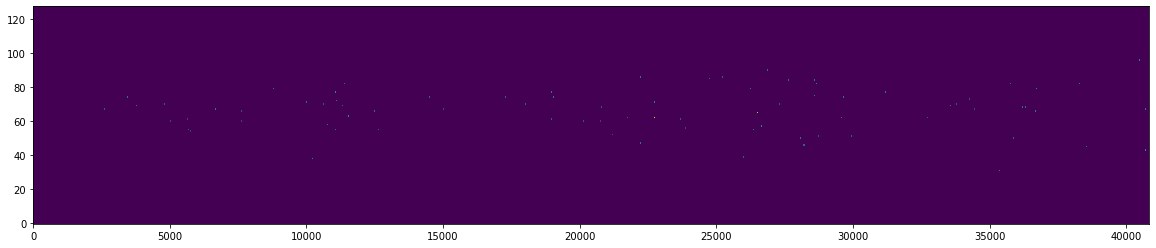

In [8]:
from Trumpet import melodyextraction
from importlib import reload
reload(melodyextraction)
mskyline=melodyextraction.mskyline

import pretty_midi as pm
midi_file="/Users/rohansharma/Desktop/Projects/Intern/score2performance/Datasets/asap-dataset/Chopin/Ballades/1/Ali01.mid"


midi_obj=pm.PrettyMIDI(midi_file)
midi_piano_roll=midi_obj.get_piano_roll(fs=100)

# plot
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20, 4))
plt.imshow(midi_piano_roll, aspect='auto', origin='lower')
plt.show()

midi_melody=mskyline(midi_file)

midi_melody.dump("temp.mid")

melody_obj=pm.PrettyMIDI("temp.mid")

melody_piano_roll=melody_obj.get_piano_roll(fs=100)

# plot
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(20, 4))
plt.imshow(melody_piano_roll, aspect='auto', origin='lower')
plt.show()

In [11]:
import miditoolkit

# count number of notes in both files
midi_obj=miditoolkit.midi.parser.MidiFile(midi_file)
melody_obj=miditoolkit.midi.parser.MidiFile("temp.mid")

midi_obj_notes=[instrument.notes for instrument in midi_obj.instruments]
melody_obj_notes=[instrument.notes for instrument in melody_obj.instruments]

midi_obj_notes=sum(midi_obj_notes,[])
melody_obj_notes=sum(melody_obj_notes,[])

print(len(midi_obj_notes))
print(len(melody_obj_notes))

5080
5743
